## Assignment 3 Breast Cancer Stage Classification

Breast cancer (BRCA) is the most common cancer in women. One important task to improve the survival rate of BRCA patients is identifying the cancer stage and applying different treatment strategies. We can train a model to classify cancer stages using RNA-seq of patient samples. 

Tasks:
1.	Prepare a dataset using TCGA-BRCA RNA-Seq data as features and cancer stages as labels. (Hint: you can find the processed RNA-Seq data and patient phenotype data from UCSC Xena)
2.	Applying data processing methods. (Normalization, Training-Test split, etc.)
3.	Applying three different classification estimators and optimizing the parameters through cross-validation.
4.	Comparing three estimators by evaluating the performance on the test dataset.
5.	Applying feature selection to improve performance.


### Task 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [3]:
reads = pd.read_csv('TCGA-BRCA.htseq_fpkm.tsv', sep='\t', header=0)
label = pd.read_csv('TCGA-BRCA.GDC_phenotype.tsv', sep='\t', header=0)

In [4]:
class classifier(object):
    def __init__(self, reads, label):
        self.reads = reads
        self.label = label
        self.data = None

    def preprossessing(self):
        '''Merge the reads and label dataframes into a single dataframe'''
        reads = self.reads.set_index('Ensembl_ID').T
        reads.reset_index(inplace=True)
        reads.rename(columns={'index':'sample_ID'}, inplace=True)

        label_first_column = self.label.columns[0]
        label.rename(columns={label_first_column:'sample_ID'}, inplace=True)
        label.rename(columns={'sample_type.samples':'sample_status'}, inplace=True) # change the name of label column
        self.label = label.loc[:,['sample_ID','sample_status']] # extract useful info
        print('data frame', reads.shape)
        data = pd.merge(reads, self.label, on='sample_ID', how='inner') # merge two dataframes
        print('merged data shape: ', data.shape)
        self.data = data
        # when the whole process is finished, the return value can be None
        return data

    def dimen_reduction(self):
        pass

    def train_test_split(self):
        '''First convert the label to binary numerical values, then split the data into training and testing sets;
        A label dictionary is created to map the numerical values back to the original labels
        '''
        # labels = self.data['sample_type.samples']
        # y = preprocessing.OneHotEncoder().fit_transform(labels.values.reshape(-1,1)).toarray()
        self.y = self.data['sample_status']
        self.X = self.data.drop(['sample_ID', 'sample_status'], axis=1)
        # self.label_dict = {0:'Metastatic', 1:'Primary Tumor', 2:'Solid Tissue Normal'}
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)

    def cross_validation(self):
        '''This function is used to search the best parameters for SVM'''
        print('-'*50)
        print('Using GridSearchCV to search the best parameters for SVM')
        from sklearn.model_selection import GridSearchCV
        param_grid = {'C': [1, 10], 'gamma': [0.1, 0.001],'kernel': ['poly', 'sigmoid']}
        grid = GridSearchCV(SVC(), param_grid,refit=True, verbose=2)
        grid.fit(self.X_train, self.y_train)
        self.best_svm_para = grid.best_params_
        print(grid.best_params_)
        
    def svm(self, params):
        if params:
            self.svm = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
        else:
            pass # still underconstruction


    def testing(self):
        pass

    def feature_selection(self):
        pass

### Action codes

In [5]:
A3 = classifier(reads, label)
data = A3.preprossessing()
A3.train_test_split()

data frame (1217, 60484)
merged data shape:  (1217, 60485)


## Below are draft

In [6]:
A3.data.sample_status.value_counts()

Primary Tumor          1097
Solid Tissue Normal     113
Metastatic                7
Name: sample_status, dtype: int64

### SVM

In [7]:
# construct multi-class SVM classifier
model = SVC(kernel='linear', gamma="auto")
model.fit(A3.X_train, A3.y_train)
y_pred = model.predict(A3.X_test)
print('Accuracy: ', accuracy_score(A3.y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(A3.y_test, y_pred))
print('Classification report: \n', classification_report(A3.y_test, y_pred))

Accuracy:  0.994535519125683
Confusion matrix: 
 [[  0   1   0]
 [  0 333   1]
 [  0   0  31]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       1.00      1.00      1.00       334
Solid Tissue Normal       0.97      1.00      0.98        31

           accuracy                           0.99       366
          macro avg       0.66      0.67      0.66       366
       weighted avg       0.99      0.99      0.99       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# model2 = SVC(kernel='poly', degree=4, gamma="auto")
model2 = SVC(kernel='sigmoid', gamma="scale")
model2.fit(A3.X_train, A3.y_train)
y_pred2 = model2.predict(A3.X_test)
print('Accuracy: ', accuracy_score(A3.y_test, y_pred2))


Accuracy:  0.9316939890710383


In [37]:
# search parameters by cross validation using GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'kernel': ['poly', 'sigmoid','linear','rbf']}
grid = GridSearchCV(SVC(), param_grid, scoring='accuracy', refit=True, verbose=3)
grid.fit(A3.X_train, A3.y_train)
best_param = grid.best_params_
print(grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .......................kernel=poly;, score=0.982 total time=   3.3s
[CV 2/5] END .......................kernel=poly;, score=0.988 total time=   3.6s
[CV 3/5] END .......................kernel=poly;, score=0.982 total time=   3.9s
[CV 4/5] END .......................kernel=poly;, score=0.994 total time=   3.4s
[CV 5/5] END .......................kernel=poly;, score=0.988 total time=   4.0s
[CV 1/5] END ....................kernel=sigmoid;, score=0.906 total time=   4.1s
[CV 2/5] END ....................kernel=sigmoid;, score=0.906 total time=   4.4s
[CV 3/5] END ....................kernel=sigmoid;, score=0.906 total time=   4.1s
[CV 4/5] END ....................kernel=sigmoid;, score=0.906 total time=   3.9s
[CV 5/5] END ....................kernel=sigmoid;, score=0.900 total time=   3.9s
[CV 1/5] END .....................kernel=linear;, score=0.982 total time=   2.6s
[CV 2/5] END .....................kernel=linear;,

In [38]:
grid.cv_results_

{'mean_fit_time': array([2.81030836, 3.17118359, 2.14024038, 3.28068957]),
 'std_fit_time': array([0.24326319, 0.17580726, 0.16205884, 0.21116582]),
 'mean_score_time': array([0.83076115, 0.90981579, 0.67536383, 2.57788138]),
 'std_score_time': array([0.04905319, 0.03340826, 0.02048553, 0.1668534 ]),
 'param_kernel': masked_array(data=['poly', 'sigmoid', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel': 'poly'},
  {'kernel': 'sigmoid'},
  {'kernel': 'linear'},
  {'kernel': 'rbf'}],
 'split0_test_score': array([0.98245614, 0.90643275, 0.98245614, 0.97660819]),
 'split1_test_score': array([0.98823529, 0.90588235, 0.98823529, 0.98823529]),
 'split2_test_score': array([0.98235294, 0.90588235, 0.98823529, 0.98823529]),
 'split3_test_score': array([0.99411765, 0.90588235, 0.99411765, 0.98823529]),
 'split4_test_score': array([0.98823529, 0.9       , 0.98823529, 0.98823529]),
 'mean_test_score': array(

In [23]:
print(grid.best_params_)
grid_predictions = grid.predict(A3.X_test)
print(confusion_matrix(A3.y_test, grid_predictions))
print(classification_report(A3.y_test, grid_predictions)) # Output

{'kernel': 'linear'}
[[  0   1   0]
 [  0 333   1]
 [  0   0  31]]
                     precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       1.00      1.00      1.00       334
Solid Tissue Normal       0.97      1.00      0.98        31

           accuracy                           0.99       366
          macro avg       0.66      0.67      0.66       366
       weighted avg       0.99      0.99      0.99       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 2000x2000 with 0 Axes>

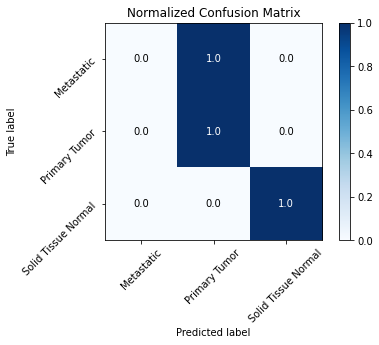

In [53]:
# draw the confusion matrix
plt.figure(figsize=(6,6),dpi=200)
skplt.metrics.plot_confusion_matrix(A3.y_test, grid_predictions, normalize=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

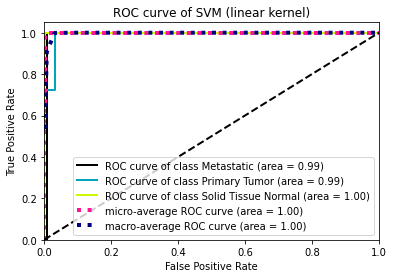

In [58]:
# draw the ROC curve
y_score = grid.decision_function(A3.X_test)
# fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
skplt.metrics.plot_roc(A3.y_test, y_score)
plt.title('ROC curve of SVM (linear kernel)')
plt.show()

In [68]:
y_score

array([[ 0.80272186,  2.26112476, -0.22805701],
       [ 0.80247116,  2.26218595, -0.23015336],
       [-0.21799443,  2.26310191,  0.78337268],
       ...,
       [ 0.8167718 ,  2.26775313, -0.24702604],
       [-0.21933766,  2.23056337,  0.91930631],
       [ 0.90719993,  2.26401511, -0.25796852]])

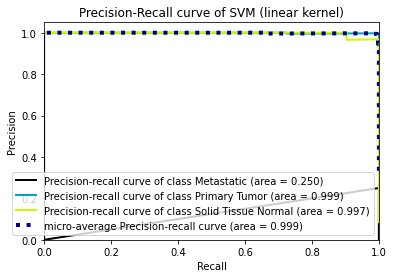

In [61]:
# plot the recall-precision curve
skplt.metrics.plot_precision_recall(A3.y_test, y_score)
plt.title('Precision-Recall curve of SVM (linear kernel)')
plt.show()

### Using Gaussian Naive Bayes to classify

In [62]:
# use naive bayes to classify
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(A3.X_train, A3.y_train)
y_pred3 = gnb.predict(A3.X_test)
print('Accuracy: ', accuracy_score(A3.y_test, y_pred3))
print('Confusion matrix: \n', confusion_matrix(A3.y_test, y_pred3))
print('Classification report: \n', classification_report(A3.y_test, y_pred3))

Accuracy:  0.912568306010929
Confusion matrix: 
 [[  0   1   0]
 [  0 334   0]
 [  0  31   0]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       0.91      1.00      0.95       334
Solid Tissue Normal       0.00      0.00      0.00        31

           accuracy                           0.91       366
          macro avg       0.30      0.33      0.32       366
       weighted avg       0.83      0.91      0.87       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion matrix of Naive Bayes')

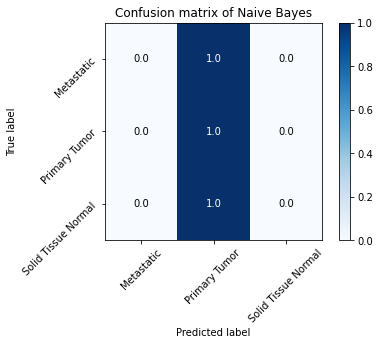

In [64]:
# confusion matrix
skplt.metrics.plot_confusion_matrix(A3.y_test, y_pred3, normalize=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion matrix of Naive Bayes')

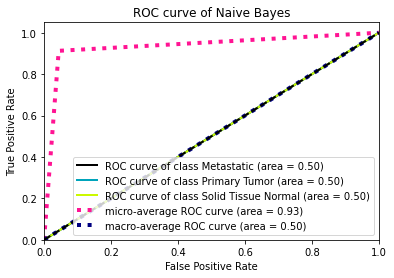

In [60]:
# draw the roc curve
y_score2 = gnb.predict_proba(A3.X_test)
skplt.metrics.plot_roc(A3.y_test, y_score2)
plt.title('ROC curve of Naive Bayes')
plt.show()

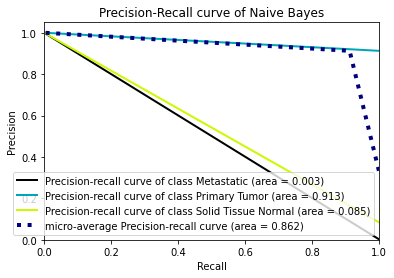

In [63]:
# draw the recall-precision curve
skplt.metrics.plot_precision_recall(A3.y_test, y_score2)
plt.title('Precision-Recall curve of Naive Bayes')
plt.show()

### Use dicision tree 

In [25]:
# decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc = DecisionTreeClassifier()
dtc.fit(A3.X_train, A3.y_train)
y_pred4 = dtc.predict(A3.X_test)
print('Accuracy: ', accuracy_score(A3.y_test, y_pred4))
print('Confusion matrix: \n', confusion_matrix(A3.y_test, y_pred4))
print('Classification report: \n', classification_report(A3.y_test, y_pred4))

Accuracy:  0.9808743169398907
Confusion matrix: 
 [[  0   1   0]
 [  0 330   4]
 [  0   2  29]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       0.99      0.99      0.99       334
Solid Tissue Normal       0.88      0.94      0.91        31

           accuracy                           0.98       366
          macro avg       0.62      0.64      0.63       366
       weighted avg       0.98      0.98      0.98       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# calculate feature weights
feature_weights = dtc.feature_importances_
feature_weights = pd.DataFrame(feature_weights, index=A3.X_train.columns, columns=['weights'])
feature_weights.sort_values(by='weights', ascending=False, inplace=True)
feature_weights.head(10)

,weights
ENSG00000165197.4,0.744297
ENSG00000099953.8,0.071129
ENSG00000275560.1,0.057347
ENSG00000279811.1,0.034315
ENSG00000103449.10,0.027935
ENSG00000185989.10,0.027452
ENSG00000137727.11,0.012565
ENSG00000136802.10,0.012549
ENSG00000133019.10,0.012412
ENSG00000242268.2,0.000000


### Use KNN to classify

In [65]:
# use KNN to classify
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(A3.X_train, A3.y_train)
y_pred6 = neigh.predict(A3.X_test)
print('Accuracy: ', accuracy_score(A3.y_test, y_pred6))
print('Confusion matrix: \n', confusion_matrix(A3.y_test, y_pred6))
print('Classification report: \n', classification_report(A3.y_test, y_pred6))

Accuracy:  0.9863387978142076
Confusion matrix: 
 [[  0   1   0]
 [  0 330   4]
 [  0   0  31]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       1.00      0.99      0.99       334
Solid Tissue Normal       0.89      1.00      0.94        31

           accuracy                           0.99       366
          macro avg       0.63      0.66      0.64       366
       weighted avg       0.98      0.99      0.99       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


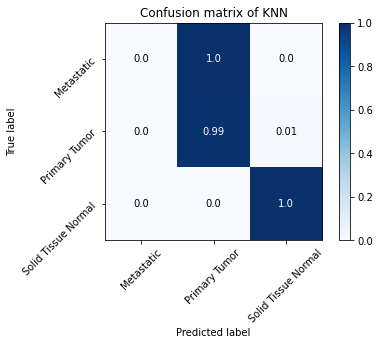

In [70]:
# draw the confusion matrix
skplt.metrics.plot_confusion_matrix(A3.y_test, y_pred6, normalize=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Confusion matrix of KNN')
plt.show()

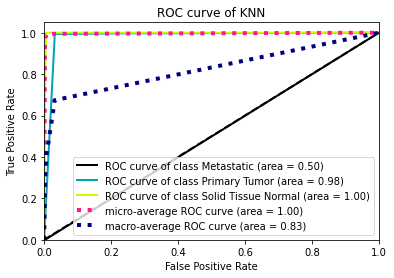

In [67]:
# draw the roc curve
y_score6 = neigh.predict_proba(A3.X_test)
skplt.metrics.plot_roc(A3.y_test, y_score6)
plt.title('ROC curve of KNN')
plt.show()

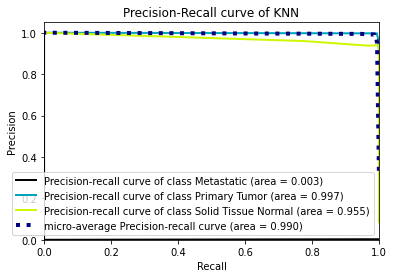

In [71]:
# draw the recall-precision curve
skplt.metrics.plot_precision_recall(A3.y_test, y_score6)
plt.title('Precision-Recall curve of KNN')
plt.show()

不太明白为什么不同的k结果几乎一样，是因为分类明显吗？

### Feature selection

In [28]:
# conduct feature selection
from sklearn.feature_selection import SelectKBest, chi2
select = SelectKBest(chi2, k=10)
X_new = select.fit_transform(A3.X, A3.y)
X_new.shape

(1217, 10)

Use the SVM to predict based on the selected features

In [29]:
# the selected features
chosen_index = select.get_support()
features = np.array(A3.X.columns)
print(features[chosen_index])

['ENSG00000167434.8' 'ENSG00000149124.9' 'ENSG00000034971.13'
 'ENSG00000168079.15' 'ENSG00000184811.3' 'ENSG00000174697.4'
 'ENSG00000165269.11' 'ENSG00000165197.4' 'ENSG00000161649.11'
 'ENSG00000187288.9']


In [30]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_new, A3.y, test_size=0.3, random_state=42)

In [31]:
# train a new SVM model using the selected features
model3 = SVC(kernel='linear', gamma="auto")
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred3))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred3))
print('Classification report: \n', classification_report(y_test, y_pred3))


Accuracy:  0.9918032786885246
Confusion matrix: 
 [[  0   1   0]
 [  0 333   1]
 [  0   1  30]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       0.99      1.00      1.00       334
Solid Tissue Normal       0.97      0.97      0.97        31

           accuracy                           0.99       366
          macro avg       0.65      0.65      0.65       366
       weighted avg       0.99      0.99      0.99       366



/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damarisdeng/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0, 1, 2]),
 [Text(0, 0, 'Metastatic'),
  Text(0, 1, 'Primary Tumor'),
  Text(0, 2, 'Solid Tissue Normal')])

<Figure size 1200x800 with 0 Axes>

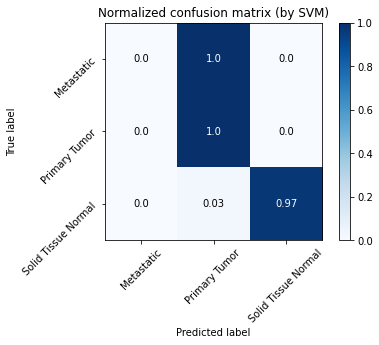

In [32]:
# plot the confusion matrix
plt.figure(dpi=200)
skplt.metrics.plot_confusion_matrix(y_test, y_pred3, normalize=True)
plt.title('Normalized confusion matrix (by SVM)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

Use decision tree to predict based on the selected features

In [33]:
# decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc2 = DecisionTreeClassifier()
dtc2.fit(X_train, y_train)
y_pred4 = dtc2.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred4))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred4))
print('Classification report: \n', classification_report(y_test, y_pred4))

Accuracy:  0.9699453551912568
Confusion matrix: 
 [[  0   1   0]
 [  4 329   1]
 [  0   5  26]]
Classification report: 
                      precision    recall  f1-score   support

         Metastatic       0.00      0.00      0.00         1
      Primary Tumor       0.98      0.99      0.98       334
Solid Tissue Normal       0.96      0.84      0.90        31

           accuracy                           0.97       366
          macro avg       0.65      0.61      0.63       366
       weighted avg       0.98      0.97      0.97       366



(array([0, 1, 2]),
 [Text(0, 0, 'Metastatic'),
  Text(0, 1, 'Primary Tumor'),
  Text(0, 2, 'Solid Tissue Normal')])

<Figure size 300x200 with 0 Axes>

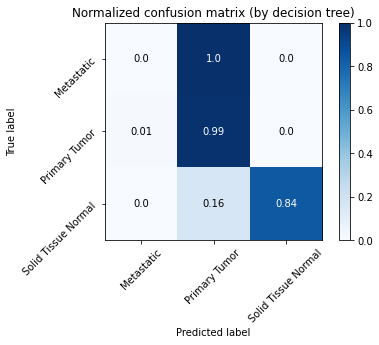

In [34]:
# visualize the confusion matrix
plt.figure(dpi=50)
skplt.metrics.plot_confusion_matrix(y_test, y_pred4, normalize=True)
plt.title('Normalized confusion matrix (by decision tree)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 300x200 with 0 Axes>

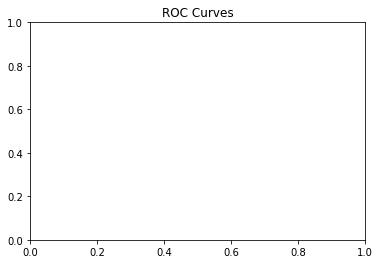

In [35]:
# plot roc curve
plt.figure(dpi=50)
skplt.metrics.plot_roc(y_test, y_pred4)
plt.title('ROC curve (by decision tree)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
